In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 543.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.0 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt


In [3]:
class build:
    @staticmethod
    def build_it():
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
model_paths = [
    '/content/drive/MyDrive/models_cc/models_2/my_model_avril_2.keras',
    '/content/drive/MyDrive/models_cc/models_2/my_model_rogelio_2.keras',
    '/content/drive/MyDrive/models_cc/models_2/my_model_fernando_2.keras',
    '/content/drive/MyDrive/models_cc/models_2/my_model_adrian_2.keras',
    '/content/drive/MyDrive/models_cc/models_2/my_model_victor_2.keras'
]

# Funciones de medidas

In [7]:
def average_weights(models):
    weights = [model.get_weights() for model in models]
    return [np.mean(np.stack(w), axis=0) for w in zip(*weights)]
def median_weights(models):
    weights = [model.get_weights() for model in models]
    return [np.median(np.stack(w), axis=0) for w in zip(*weights)]
def trimmed_mean_weights(models, trim_ratio=0.25):
    weights = [model.get_weights() for model in models]
    trimmed = []
    for layers in zip(*weights):
        stacked = np.stack(layers)
        lower = int(trim_ratio * len(stacked))
        upper = len(stacked) - lower
        sorted_stack = np.sort(stacked, axis=0)
        trimmed.append(np.mean(sorted_stack[lower:upper], axis=0))
    return trimmed

In [8]:
test_path = "/content/drive/MyDrive/models_cc/subsets_2/mnist_global_test.parquet"
df_test = pd.read_parquet(test_path)
x_test = df_test.drop("label", axis=1).values.reshape(-1, 28, 28, 1) / 255.0
y_test = df_test["label"].values

In [10]:
data_path = '/content/drive/MyDrive/models_cc/subsets_2/'
client_data = []
for i in range(1, 6):
    df = pd.read_parquet(os.path.join(data_path, f'mnist_client{i}.parquet'))
    x = df.drop("label", axis=1).values.reshape(-1, 28, 28, 1) / 255.0
    y = df["label"].values
    client_data.append((x, y))

In [13]:
client_models = [tf.keras.models.load_model(p) for p in model_paths]
accuracies = {}
methods = {
    'FedAvg': average_weights,
    'FedMedian': median_weights,
    'TrimmedMean': trimmed_mean_weights
}

for name, func in methods.items():
    print(f"\nEvaluando {name}")
    weights = func(client_models)
    model = build.build_it()
    model.set_weights(weights)
    preds = np.argmax(model.predict(x_test, verbose=0), axis=1)
    acc = accuracy_score(y_test, preds)
    accuracies[name] = acc
    print(classification_report(y_test, preds))
    model.save(f"/content/drive/MyDrive/models_cc/global_model_{name.lower()}.keras")



Evaluando FedAvg
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       987
           1       0.97      0.99      0.98      1124
           2       0.98      0.92      0.95       993
           3       0.88      0.99      0.93      1022
           4       0.98      0.97      0.98       974
           5       0.96      0.99      0.97       903
           6       0.99      0.97      0.98       986
           7       0.92      0.99      0.96      1044
           8       0.99      0.86      0.92       975
           9       0.98      0.94      0.96       992

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


Evaluando FedMedian
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       987
           1       0.99      0.99      0.99      1124
           2       0.99      0.96      

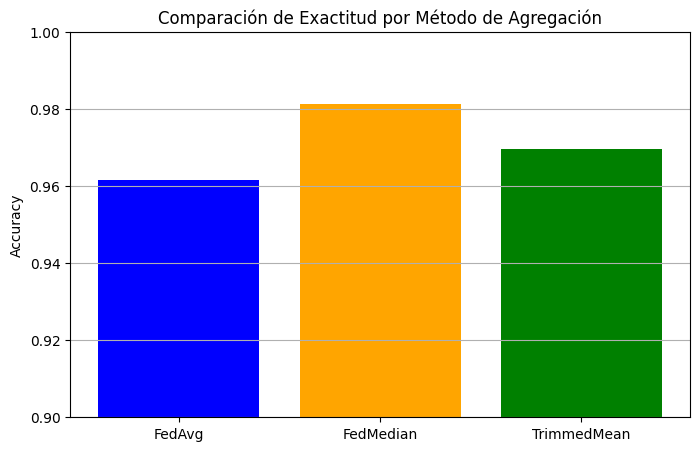

In [14]:
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'orange', 'green'])
plt.title("Comparación de Exactitud por Método de Agregación")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.grid(True, axis='y')
plt.savefig('/content/drive/MyDrive/models_cc/global_comparison_plot.png')
plt.show()


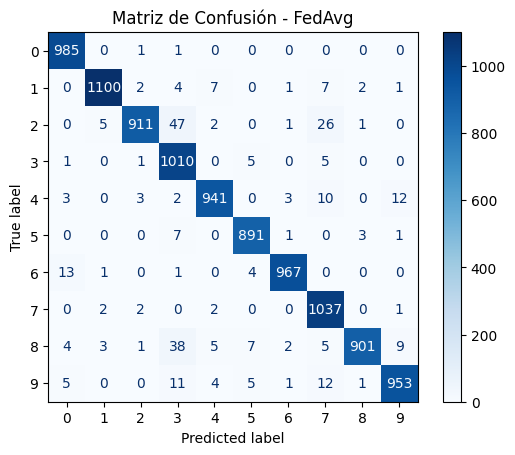

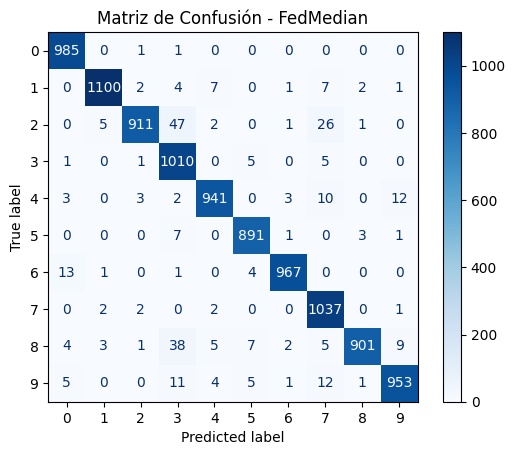

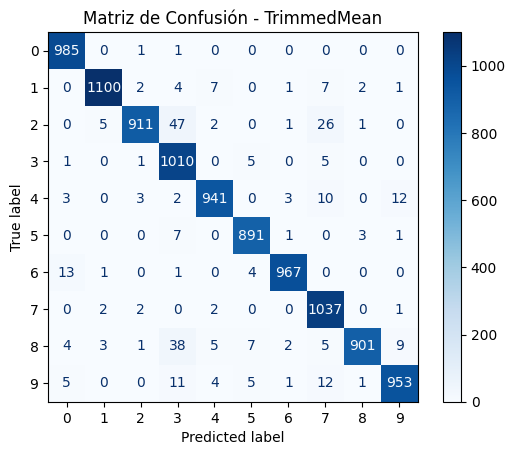

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for name, func in methods.items():
    ...
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Matriz de Confusión - {name}')
    plt.savefig(f'/content/drive/MyDrive/models_cc/conf_matrix_{name.lower()}.png')
    plt.show()


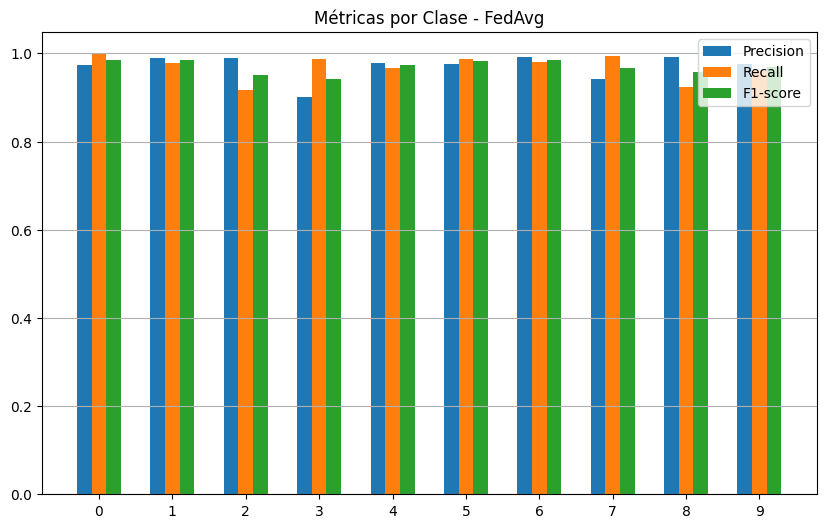

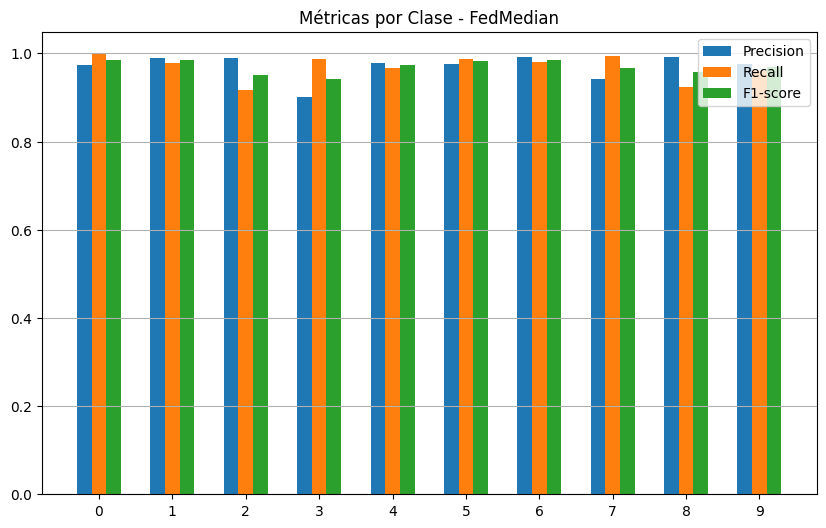

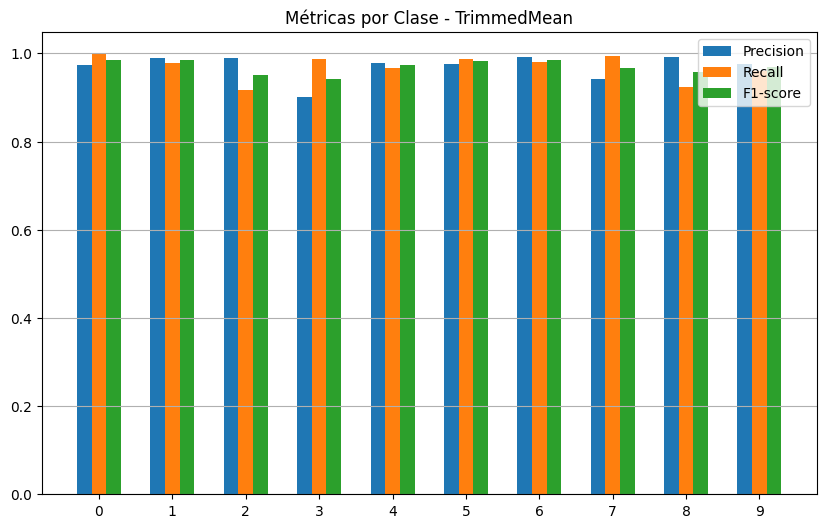

In [16]:
from sklearn.metrics import precision_recall_fscore_support

for name, func in methods.items():
    ...
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds)
    labels = [str(i) for i in range(10)]
    x = np.arange(len(labels))

    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.2, precision, width=0.2, label='Precision')
    plt.bar(x, recall, width=0.2, label='Recall')
    plt.bar(x + 0.2, f1, width=0.2, label='F1-score')
    plt.xticks(x, labels)
    plt.title(f'Métricas por Clase - {name}')
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig(f'/content/drive/MyDrive/models_cc/metrics_per_class_{name.lower()}.png')
    plt.show()
